In [38]:
#!pip install lifelines
import warnings
warnings.filterwarnings('ignore')

# 1. Estimating the survival function using Kaplan-Meier

https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html

In [5]:
from lifelines.datasets import load_dd

data= load_dd()
data.head()

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
0,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...,Non-democracy,Monarchy,1946,7,1
1,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1953.1962.Ci...,Non-democracy,Civilian Dict,1953,10,1
2,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1963.1972.Mona...,Non-democracy,Monarchy,1963,10,1
3,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1973.1977.Ci...,Non-democracy,Civilian Dict,1973,5,0
4,Afghanistan,700,700.0,Southern Asia,Asia,Nur Mohammad Taraki,Nur Mohammad Taraki.Afghanistan.1978.1978.Civi...,Non-democracy,Civilian Dict,1978,1,0


### Fitting and plotting 

In [7]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

T = data['duration']   #Right handed data
E = data['observed']   #Censored data (1 for died and 0 for suspended)

kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1808 total observations, 340 right-censored observations>

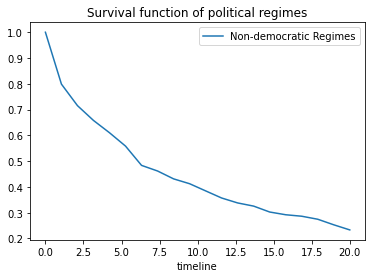

In [42]:
import matplotlib.pyplot as plt

kmf.survival_function_.plot()
plt.title('Survival function of political regimes');

6.315789473684211

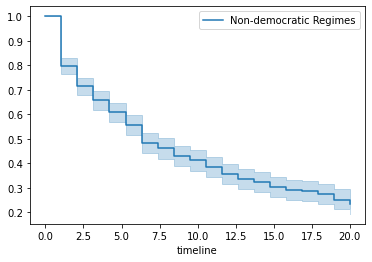

In [44]:
kmf.plot_survival_function()
kmf.percentile(0.5)

In [18]:
#To get the confidence interval of the median
from lifelines.utils import median_survival_times
median_ci = median_survival_times(kmf.confidence_interval_)
median_ci

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.5,3.0,4.0


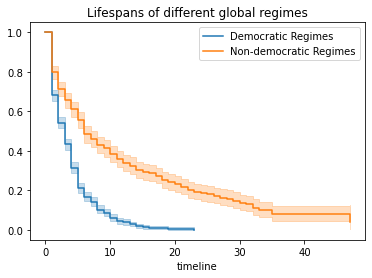

In [21]:
#democratic regimes vs non-democratic regimes

ax = plt.subplot(111)

kmf.fit(T[dem], event_observed=E[dem], label='Democratic Regimes')
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~dem], event_observed=E[~dem], label='Non-democratic Regimes')
kmf.plot_survival_function(ax=ax)

plt.title("Lifespans of different global regimes");

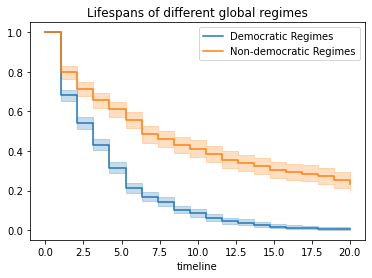

In [27]:
import numpy as np
ax = plt.subplot(111)

t=np.linspace(0,20,20)
kmf.fit(T[dem], event_observed=E[dem], timeline=t, label='Democratic Regimes')
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~dem], event_observed=E[~dem], timeline=t, label='Non-democratic Regimes')
kmf.plot_survival_function(ax=ax)

plt.title("Lifespans of different global regimes");

Here the difference between survival functions is very obvious, and performing a statistical test seems pedantic. If the curves are more similar, or we possess less data, we may be interested in performing a statistical test. In this case, lifelines contains routines in lifelines.statistics to compare two survival functions. Below we demonstrate this routine. The function lifelines.statistics.logrank_test() is a common statistical test in survival analysis that compares two event series’ generators. If the value returned exceeds some pre-specified value, then we rule that the series have different generators.

In [55]:
from lifelines.statistics import logrank_test

results = logrank_test(T[dem], T[~dem],E[dem], E[~dem], alpha=0.95)
results.print_summary()
print(results.p_value)        # 0.46759
print(results.test_statistic) # 0.528

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         260.47 <0.005    192.23

1.3557143218483999e-58
260.4695390779592


Lets compare the different types of regimes present in the dataset:

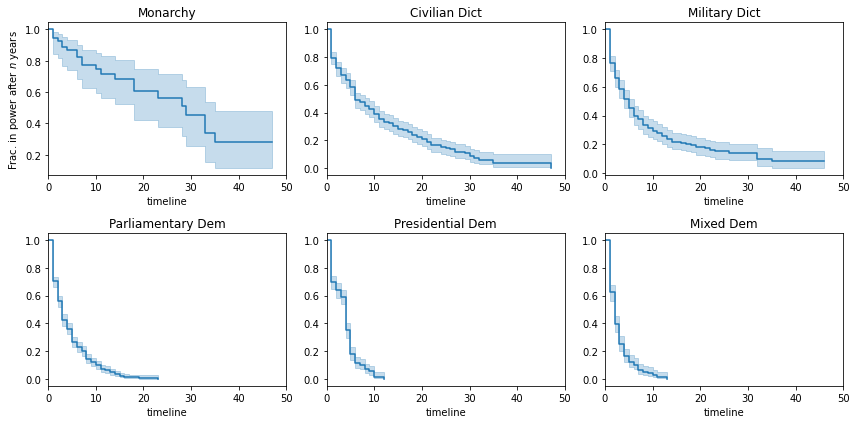

In [62]:
regime_types = data['regime'].unique()

plt.figure(figsize=(12,6))
for i, regime_type in enumerate(regime_types):
    ax = plt.subplot(2, 3, i + 1)

    ix = data['regime'] == regime_type
    kmf.fit(T[ix], E[ix], label=regime_type)
    kmf.plot_survival_function(ax=ax, legend=False)

    plt.title(regime_type)
    plt.xlim(0, 50)

    if i==0:
        plt.ylabel('Frac. in power after $n$ years')

plt.tight_layout()

### Best practices for presenting Kaplan Meier plots

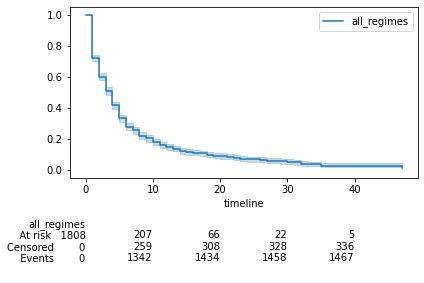

In [65]:
kmf = KaplanMeierFitter().fit(T, E, label="all_regimes")
kmf.plot_survival_function(at_risk_counts=True)
plt.tight_layout()

Getting data into the right format

lifelines data format is consistent across all estimator class and functions: an array of individual durations, and the individuals event observation (if any). These are often denoted T and E respectively. For example:

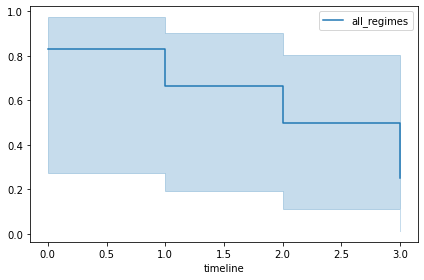

In [68]:
T = [0, 3, 3, 2, 1, 2]
E = [1, 1, 0, 0, 1, 1]
kmf.fit(T, event_observed=E)
kmf.plot_survival_function()
plt.tight_layout()

The raw data is not always available in this format – lifelines includes some helper functions to transform data formats to lifelines format. These are located in the lifelines.utils sub-library. For example, the function datetimes_to_durations() accepts an array or Pandas object of start times/dates, and an array or Pandas objects of end times/dates (or None if not observed):

In [69]:
from lifelines.utils import datetimes_to_durations

start_date = ['2013-10-10 0:00:00', '2013-10-09', '2013-10-10']
end_date = ['2013-10-13', '2013-10-10', None]
T, E = datetimes_to_durations(start_date, end_date, fill_date='2013-10-15')
print('T (durations): ', T)
print('E (event_observed): ', E)

T (durations):  [3. 1. 5.]
E (event_observed):  [ True  True False]


In [73]:
#By month
start_date = ['2013-10-10 0:00:00', '2013-10-09', '2013-10-10']
end_date = ['2014-10-13', '2015-10-10', None]
T, E = datetimes_to_durations(start_date, end_date, fill_date='2016-10-15', freq="M")
print('T (durations): ', T)
print('E (event_observed): ', E)

T (durations):  [12. 24. 36.]
E (event_observed):  [ True  True False]


## 2. Estimating hazard rates using Nelson-Aalen
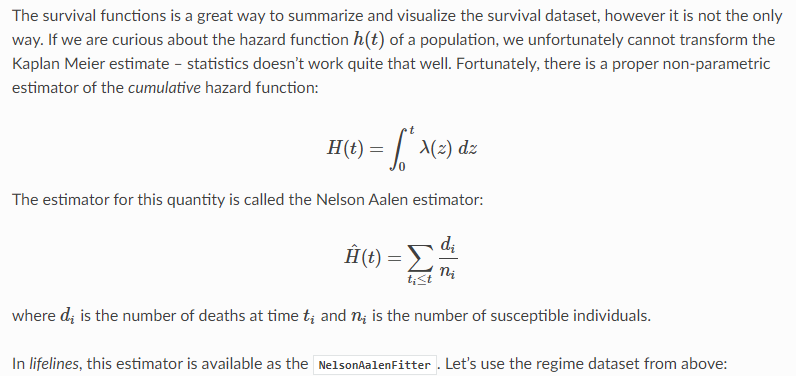

          NA_estimate
timeline             
0.0          0.000000
1.0          0.325912
2.0          0.507356
3.0          0.671251
4.0          0.869867


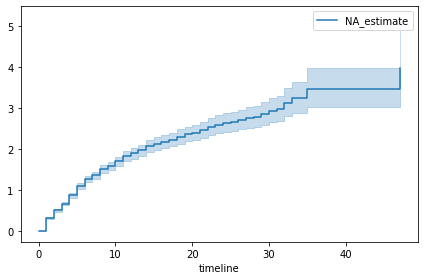

In [79]:
T = data["duration"]
E = data["observed"]

from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(T,event_observed=E)

#After fitting, the class exposes the property cumulative_hazard_`() as a DataFrame:
print(naf.cumulative_hazard_.head())
naf.plot_cumulative_hazard()
plt.tight_layout()

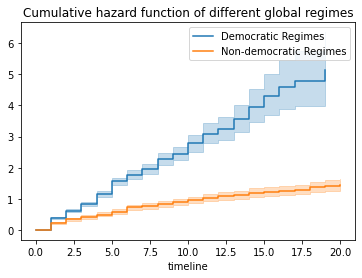

In [80]:
naf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
ax = naf.plot_cumulative_hazard(loc=slice(0, 20))

naf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
naf.plot_cumulative_hazard(ax=ax, loc=slice(0, 20))

plt.title("Cumulative hazard function of different global regimes");

## Smoothing the hazard function

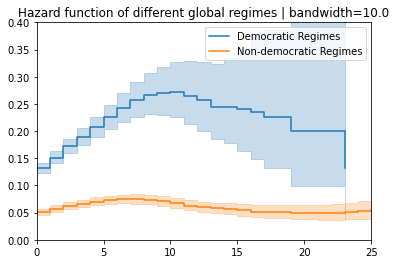

In [90]:
bandwidth = 10.

naf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
ax = naf.plot_hazard(bandwidth=bandwidth)

naf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
naf.plot_hazard(ax=ax, bandwidth=bandwidth)

plt.title("Hazard function of different global regimes | bandwidth=%.1f" % bandwidth);
plt.ylim(0, 0.4)
plt.xlim(0, 25);

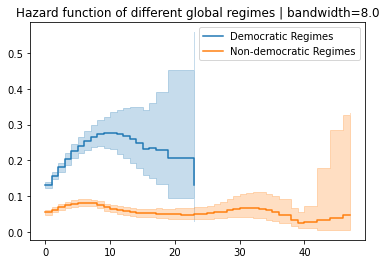

In [91]:
bandwidth = 8.0

naf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
ax = naf.plot_hazard(bandwidth=bandwidth)

naf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
naf.plot_hazard(ax=ax, bandwidth=bandwidth)

plt.title("Hazard function of different global regimes | bandwidth=%.1f" % bandwidth);

# Estimating cumulative hazards using parametric models
# 3. Fitting to a Weibull model

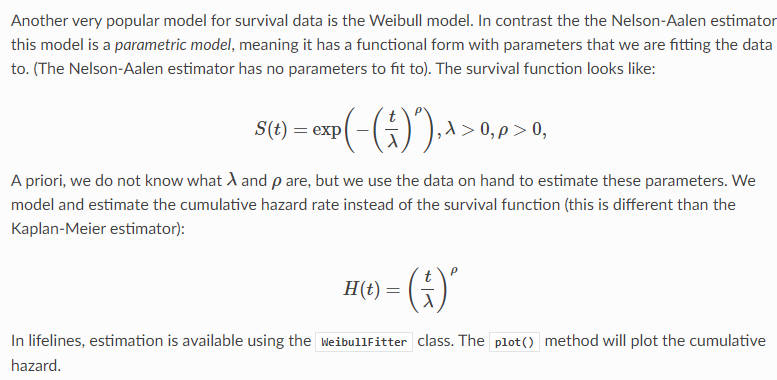

In [128]:
from lifelines import WeibullFitter
from lifelines.datasets import load_waltons

data = load_waltons()

T = data['T']
E = data['E']

wf = WeibullFitter().fit(T, E)
wf.print_summary()

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 163 total observations, 7 right-censored observations>
   number of observations = 163
number of events observed = 156
           log-likelihood = -672.06
               hypothesis = lambda_ != 1, rho_ != 1

---
          coef   se(coef)   coef lower 95%   coef upper 95%     z      p   -log2(p)
lambda_  55.73       1.33            53.13            58.33 41.26 <0.005        inf
rho_      3.45       0.24             2.97             3.93 10.07 <0.005      76.83
---
AIC = 1348.12

In [141]:
#Get the parameters
wf.params_

lambda_    55.733097
rho_        3.450505
Name: coef, dtype: float64

In [142]:
wf.median_survival_time_

50.116690840671254

### Cumulative hazard

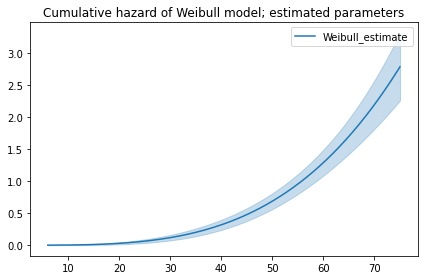

In [130]:
ax = wf.plot_cumulative_hazard()
ax.set_title("Cumulative hazard of Weibull model; estimated parameters")
plt.tight_layout()

### Hazard

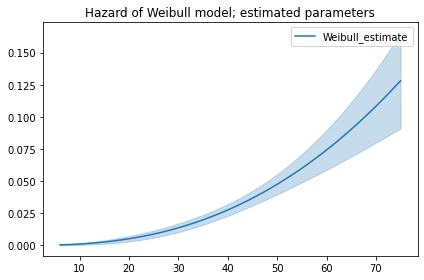

In [131]:
ax = wf.plot_hazard()
ax.set_title("Hazard of Weibull model; estimated parameters")
plt.tight_layout()

In [149]:
wf.hazard_at_times([15,25,35,50,65,70,75])

15    0.002483
25    0.008681
35    0.019800
50    0.047451
65    0.090253
70    0.108226
75    0.128161
Name: Weibull_estimate, dtype: float64

### Survival Function

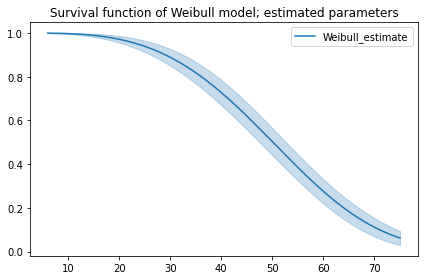

In [133]:
ax = wf.plot_survival_function()
ax.set_title("Survival function of Weibull model; estimated parameters")
plt.tight_layout()

Get the value ot time at wihch there is a 90% of produciton is survival?

In [134]:
wf.percentile(0.9)

29.031728822027784

At 40 time what is the cummulative survial rate?

In [143]:
wf.survival_function_at_times(50)

50    0.502784
Name: Weibull_estimate, dtype: float64

### Density function

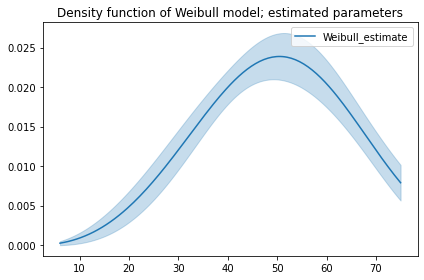

In [138]:
ax = wf.plot_density()
ax.set_title("Density function of Weibull model; estimated parameters")
plt.tight_layout()

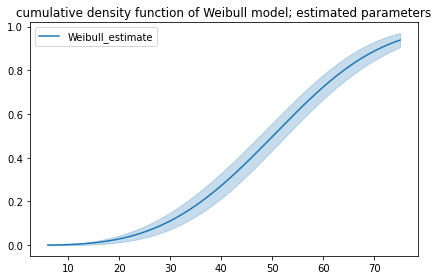

In [139]:
ax = wf.plot_cumulative_density()
ax.set_title("cumulative density function of Weibull model; estimated parameters")
plt.tight_layout()

# 4. Other parametric models: Exponential, Log-Logistic, Log-Normal and Splines

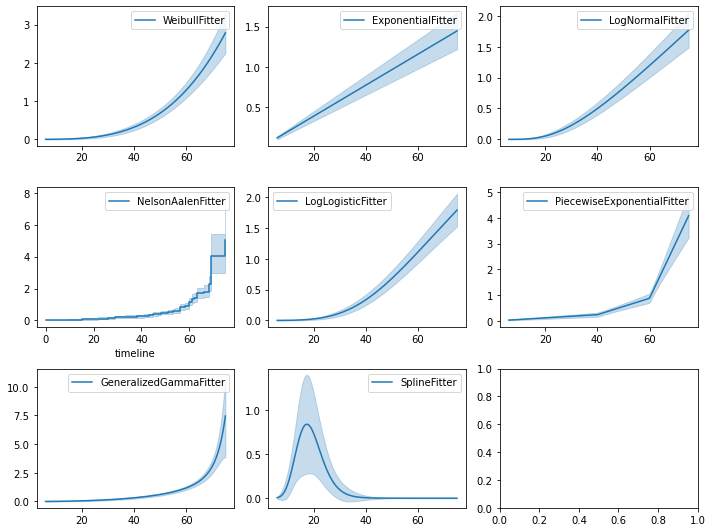

In [151]:
from lifelines import (WeibullFitter, ExponentialFitter,
LogNormalFitter, LogLogisticFitter, NelsonAalenFitter,
PiecewiseExponentialFitter, GeneralizedGammaFitter, SplineFitter)

from lifelines.datasets import load_waltons
data = load_waltons()

fig, axes = plt.subplots(3, 3, figsize=(10, 7.5))

T = data['T']
E = data['E']

wbf = WeibullFitter().fit(T, E, label='WeibullFitter')
exf = ExponentialFitter().fit(T, E, label='ExponentialFitter')
lnf = LogNormalFitter().fit(T, E, label='LogNormalFitter')
naf = NelsonAalenFitter().fit(T, E, label='NelsonAalenFitter')
llf = LogLogisticFitter().fit(T, E, label='LogLogisticFitter')
pwf = PiecewiseExponentialFitter([40, 60]).fit(T, E, label='PiecewiseExponentialFitter')
gg = GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter')
spf = SplineFitter([6, 20, 40, 75]).fit(T, E, label='SplineFitter')

wbf.plot_cumulative_hazard(ax=axes[0][0])
exf.plot_cumulative_hazard(ax=axes[0][1])
lnf.plot_cumulative_hazard(ax=axes[0][2])
naf.plot_cumulative_hazard(ax=axes[1][0])
llf.plot_cumulative_hazard(ax=axes[1][1])
pwf.plot_cumulative_hazard(ax=axes[1][2])
gg.plot_cumulative_hazard(ax=axes[2][0])
spf.plot_cumulative_hazard(ax=axes[2][1])
plt.tight_layout()

Parametric models can also be used to create and plot the survival function, too. Below we compare the parametric models versus the non-parametric Kaplan-Meier estimate:

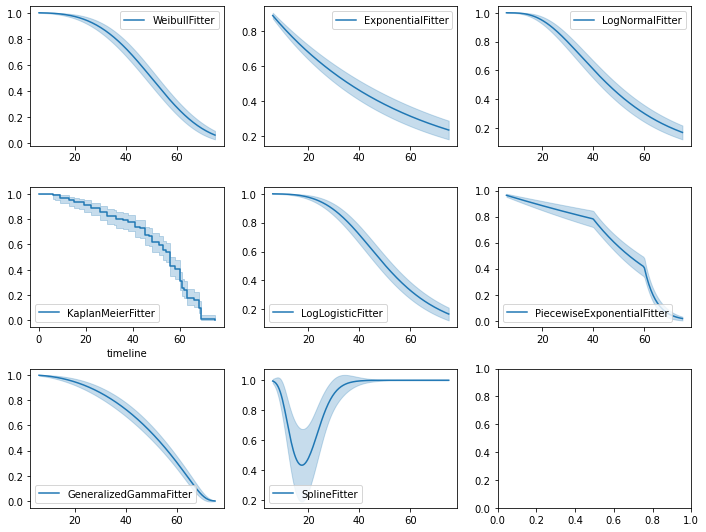

In [153]:
from lifelines import KaplanMeierFitter

fig, axes = plt.subplots(3, 3, figsize=(10, 7.5))

T = data['T']
E = data['E']

kmf = KaplanMeierFitter().fit(T, E, label='KaplanMeierFitter')
wbf = WeibullFitter().fit(T, E, label='WeibullFitter')
exf = ExponentialFitter().fit(T, E, label='ExponentialFitter')
lnf = LogNormalFitter().fit(T, E, label='LogNormalFitter')
llf = LogLogisticFitter().fit(T, E, label='LogLogisticFitter')
pwf = PiecewiseExponentialFitter([40, 60]).fit(T, E, label='PiecewiseExponentialFitter')
gg = GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter')
spf = SplineFitter([6, 20, 40, 75]).fit(T, E, label='SplineFitter')

wbf.plot_survival_function(ax=axes[0][0])
exf.plot_survival_function(ax=axes[0][1])
lnf.plot_survival_function(ax=axes[0][2])
kmf.plot_survival_function(ax=axes[1][0])
llf.plot_survival_function(ax=axes[1][1])
pwf.plot_survival_function(ax=axes[1][2])
gg.plot_survival_function(ax=axes[2][0])
spf.plot_survival_function(ax=axes[2][1])
plt.tight_layout()

With parametric models, we have a functional form that allows us to extend the survival function (or hazard or cumulative hazard) past our maximum observed duration. This is called extrapolation. We can do this in a few ways.

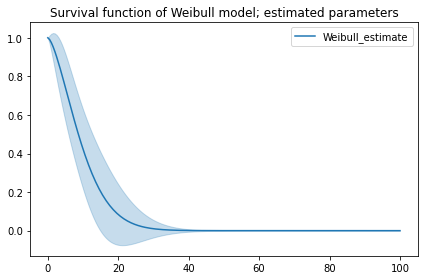

In [221]:
timeline = np.linspace(0, 100, 200)

# directly compute the survival function, these return a pandas Series
wbf = WeibullFitter().fit(T, E)
wbf.survival_function_at_times(timeline)
wbf.hazard_at_times(timeline)
wbf.cumulative_hazard_at_times(timeline)

# use the `timeline` kwarg in `fit`
# by default, all functions and properties will use
# these values provided
wbf = WeibullFitter().fit(T, E, timeline=timeline)

ax = wbf.plot_survival_function()
ax.set_title("Survival function of Weibull model; estimated parameters")
plt.tight_layout()

In [157]:
T.describe()

count    163.000000
mean      49.613497
std       17.078007
min        6.000000
25%       41.000000
50%       56.000000
75%       61.000000
max       75.000000
Name: T, dtype: float64

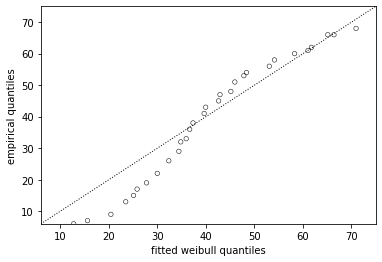

In [160]:
from lifelines.plotting import qq_plot
qq_plot(wbf);


# Selecting a parametric model using QQ plots

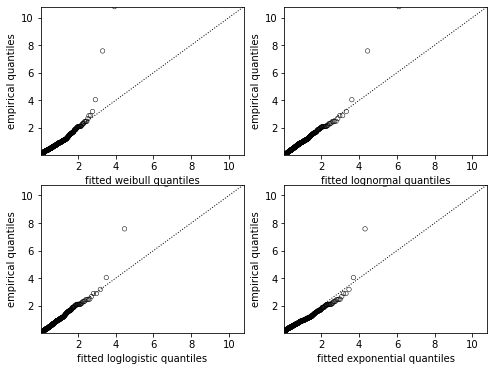

In [161]:
from lifelines import *
from lifelines.plotting import qq_plot

# generate some fake log-normal data
N = 1000
T_actual = np.exp(np.random.randn(N))
C = np.exp(np.random.randn(N))
E = T_actual < C
T = np.minimum(T_actual, C)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.reshape(4,)

for i, model in enumerate([WeibullFitter(), LogNormalFitter(), LogLogisticFitter(), ExponentialFitter()]):
    model.fit(T, E)
    qq_plot(model, ax=axes[i])

# Selecting a parametric model using AIC

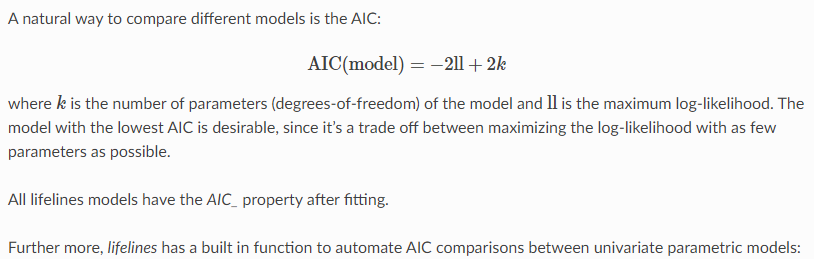

<lifelines.SplineFitter:"SplineFitter: 2 internal knot", fitted with 686 total observations, 387 right-censored observations>


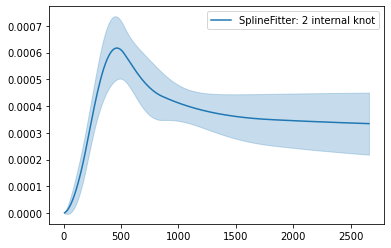

In [164]:
from lifelines.utils import find_best_parametric_model
from lifelines.datasets import load_lymph_node

T = load_lymph_node()['rectime']
E = load_lymph_node()['censrec']

best_model, best_aic_ = find_best_parametric_model(T, E, scoring_method="AIC")

print(best_model)
# <lifelines.SplineFitter:"Spline_estimate", fitted with 686 total observations, 387 right-censored observations>

best_model.plot_hazard();

# Plotting interval censored data

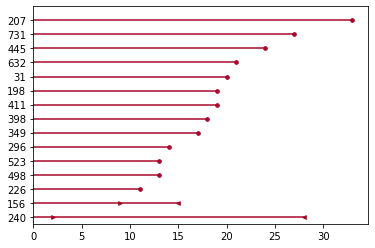

In [166]:
from lifelines.datasets import load_diabetes
from lifelines.plotting import plot_interval_censored_lifetimes

df_sample = load_diabetes().sample(frac=0.02)
ax = plot_interval_censored_lifetimes(df_sample['left'], df_sample['right'])

# Transforming survival-table data into lifelines format

In [202]:
import pandas as pd
df = pd.DataFrame({'time':range(5), 'deaths_obs':[7,1,2,5,9], 'censored':[0,1,0,2,2]})
df= df.set_index('time')
df

,deaths_obs,censored
time,,
0,7,0
1,1,1
2,2,0
3,5,2
4,9,2


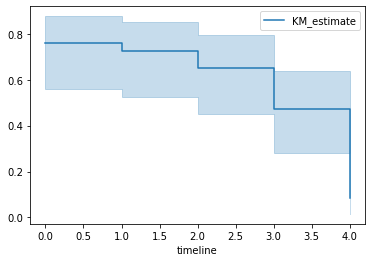

In [203]:
from lifelines.utils import survival_events_from_table

T, E, W = survival_events_from_table(df, observed_deaths_col='deaths_obs', censored_col='censored')
# weights, W, is the number of occurrences of each observation - helps with data compression.

pd.DataFrame({'T':T, 'E':E, 'W':W})

kmf = KaplanMeierFitter().fit(T, E, weights=W)
kmf.plot_survival_function();

### My own example

In [206]:
df = pd.DataFrame({'time':[1,2,4,5,6,7,8,9], 'fails':[3,2,2,0,1,1,1,1], 'censored':[0,0,46,80,98,118,99,79]})
df= df.set_index('time')
df

,fails,censored
time,,
1,3,0
2,2,0
4,2,46
5,0,80
6,1,98
7,1,118
8,1,99
9,1,79


In [207]:
T, E, W = survival_events_from_table(df, observed_deaths_col='fails', censored_col='censored')
# weights, W, is the number of occurrences of each observation - helps with data compression.

pd.DataFrame({'T':T, 'E':E, 'W':W})

,T,E,W
0,1,1,3
1,2,1,2
2,4,1,2
3,4,0,46
4,5,0,80
5,6,1,1
6,6,0,98
7,7,1,1
8,7,0,118
9,8,1,1


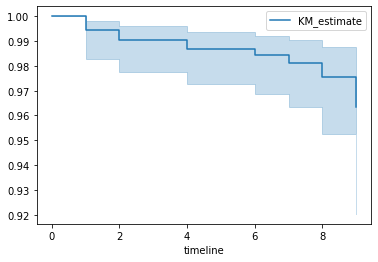

In [208]:
kmf = KaplanMeierFitter().fit(T, E, weights=W)
kmf.plot_survival_function();

In [209]:
wf = WeibullFitter().fit(T, E, weights=W)
wf.print_summary()

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 531 total observations, 520 right-censored observations>
   number of observations = 531
number of events observed = 11
           log-likelihood = -74.35
               hypothesis = lambda_ != 1, rho_ != 1

---
          coef   se(coef)   coef lower 95%   coef upper 95%    z    p   -log2(p)
lambda_ 170.38     164.11          -151.27           492.03 1.03 0.30       1.73
rho_      1.20       0.35             0.52             1.88 0.57 0.57       0.82
---
AIC = 152.70

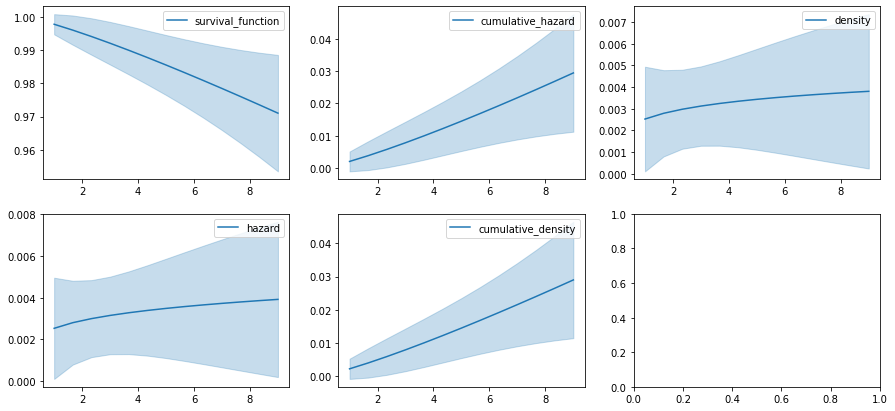

In [210]:
fig, axes = plt.subplots(2,3, figsize=(15,7))

wf.plot_survival_function(ax=axes[0][0], label='survival_function');
wf.plot_cumulative_hazard(ax=axes[0][1], label='cumulative_hazard');
wf.plot_density(ax=axes[0][2], label='density');
wf.plot_hazard(ax=axes[1][0], label='hazard');
wf.plot_cumulative_density(ax=axes[1][1], label='cumulative_density');

### Example 2

In [224]:
df= pd.read_csv('data/failures study cars.csv')
df

,cycles,risk,fail,suspended
0,0,95000,0,0
1,1,95000,124,0
2,3,94876,56,0
3,5,94820,118,0
4,6,94702,28,0
5,7,94674,109,0
6,10,94565,14,0
7,13,94551,179,0
8,14,94372,32,0
9,15,94340,46,0


In [225]:
T, E, W = survival_events_from_table(df, observed_deaths_col='fail', censored_col='suspended')
# weights, W, is the number of occurrences of each observation - helps with data compression.

pd.DataFrame({'T':T, 'E':E, 'W':W})

,T,E,W
0,1,1,124
1,2,1,56
2,3,1,118
3,4,1,28
4,5,1,109
5,6,1,14
6,7,1,179
7,8,1,32
8,9,1,46
9,10,1,86


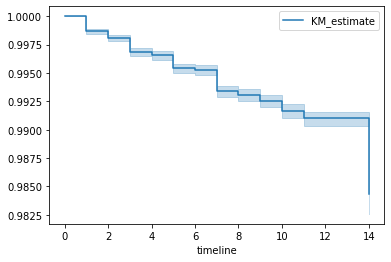

In [226]:
kmf = KaplanMeierFitter().fit(T, E, weights=W)
kmf.plot_survival_function();

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 95000 total observations, 94098 right-censored observations>
   number of observations = 95000
number of events observed = 902
           log-likelihood = -7298.27
               hypothesis = lambda_ != 1, rho_ != 1

---
          coef   se(coef)   coef lower 95%   coef upper 95%    z      p   -log2(p)
lambda_ 749.28     105.40           542.70           955.85 7.10 <0.005      39.54
rho_      1.11       0.04             1.04             1.19 3.12 <0.005       9.10
---
AIC = 14600.55

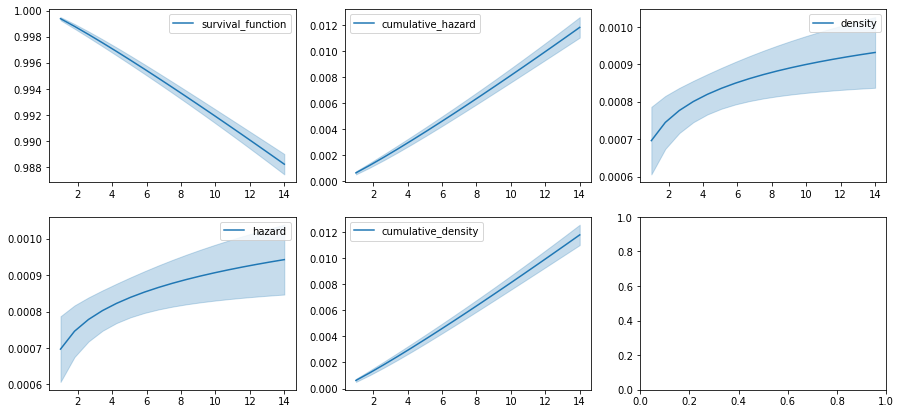

In [228]:
wf = WeibullFitter().fit(T, E, weights=W)
wf.print_summary()

fig, axes = plt.subplots(2,3, figsize=(15,7))

wf.plot_survival_function(ax=axes[0][0], label='survival_function');
wf.plot_cumulative_hazard(ax=axes[0][1], label='cumulative_hazard');
wf.plot_density(ax=axes[0][2], label='density');
wf.plot_hazard(ax=axes[1][0], label='hazard');
wf.plot_cumulative_density(ax=axes[1][1], label='cumulative_density');

# Transforming observational data into survival-table format

In [204]:
from lifelines.utils import survival_table_from_events

table = survival_table_from_events(T, E)
print(table.head())

          removed  observed  censored  entrance  at_risk
event_at                                                
0               1         1         0         8        8
1               2         1         1         0        7
2               1         1         0         0        5
3               2         1         1         0        4
4               2         1         1         0        2


In [230]:
import numpy as np